# Dask

## Threads and processes

It is important to be comfortable with these two terms before procedding.

1) Processes: A process, in the simplest terms, is an executing program. One or more threads run in the context of the process.

2) Threads: A thread is the basic unit to which the operating system allocates processor time. A thread can execute any part of a program, including parts currently being executed by another thread. Threads in a same process have shared memory.

Source: [Microsoft Docs](https://docs.microsoft.com/en-us/windows/win32/procthread/processes-and-threads)

When multithreading term is used, it basically means a bunch of threads running independently but sharing memory within a single process. It can mean having parallel computing capabilities in languages like C/C++ etc or when doing I/O or network operations. But in python because of the Global Interpretor Lock(GIL), only one thread can run execution at one time in a process. 
So essentially, if you are using multithreading in pure python code, then it gives similar performance to single-threaded execution. Only multiprocessing can give parallel execution performance for pure python code computations.

## Introduction to Dask

Dask is a popular library for parallel and distributed computing in Python. It has a familiar and easy to use API and also provides low level interfaces to create your own custom workloads.

The motivation to use dask is nicely outlined in this [article](https://docs.dask.org/en/latest/why.html). But to summarize their points:
 
1) **Dask enables** computations to scale out to multiple machines, with easy to debug and robust interfaces. 
2) **Dask enhances** your local system's computational capabilities by leveraging multiple cores to compute in parallel (if the program can be parallelized).
3) **Dask integrates** with and complements the existing pyData ecosystem and tools like numpy, pandas, scikit-learn etc. It copies most of their APIs to go parallel and distributed. These are called **high-level APIs**.
4) **Dask supports** complex applications as well, by giving access to its **low-level APIs** used to create its own internal task scheduler. 
5) **Dask delivers** rich and responsive feedbacks on computations by providing a dashboard where you can view how the task is porgressing.

We will touch each of these points in this article. But first let's see the internal machanisms of dask briefly. Internal mechanisms are necessary to understand that dask cannot magically make every computation faster. Infact because of the overhead of adding dask, your code may actually become a little slower in certain cases. 

## Dask computation phases

Each computation goes through three phases in dask:

### 1) User-interface/Client:

This is the user-interface part of dask. The code which we write, and the functions which we use. This generates a high-level graph where each node corresponds to roughly one operation in your code. This high-level graph is then translated to a low-level graph where one node is roughly one single task to be executed in a worker (a blueprint of the whole computation). Then this low-level graph is optimized to create a more efficient blueprint. It is serialized and passed on to the scheduler.

### 2) Scheduler:

The scheduler is like a supervisor which oversees all computations done. The low-level task graph is received by the scheduler, and then semi-deserialized and pushed to its internal state machine. This state machine works on-the-fly and tells every worker what tasks to compute.
As we can expect, the scheduler engages in real-time conversation with the workers, and passes computed results, dependencies and messages between workers as needed. In the end, it receives the final output and passes it on to the client. 

There are four types of schedulers:

1) Synchronous :- This scheduler does all computations in the local thread, with no parallelism. Useful for code debugging purposes.

2) Threaded :- This scheduler uses multi-threading in a single process. The parallelism of this scheduler depends on the task at hand. If the task is pure python code, then it will essentially be synchronous because of the Global Interpretor Lock(GIL) of Python. But, if you are doing I/O operations, or using packages like numpy, pandas which release the GIL most of the times, or other non-pure python code/packages to do computation then it can go parallel. All the threads share the same memory so there is no overhead in communication.

3) Multiprocessing :- This scheduler uses a process to run each task, which bypasses the GIL, and provides parallelism on pure python code. Downside is that each process has its own memory, so communicating between tasks can be expensive, as it involves serialization and deserilaization. 

4) Distributed :- Contrary to its name, this scheduler can also be setup locally apart from setting it up on a cluster. It can be both multithreading or multiprocessing based on the configuration provided, but is multiprocessing by default. This scheduler is the one which provides a dashboard, for debugging and profiling. And gives access to asynchronous API, notably Futures. A proper term to describe it would be an advanced scheduler rather then distributed. They have to be installed on top of dask and have their own documentation [page](https://distributed.dask.org/en/latest/)

### 3) Workers:

The workers themselves are the ones who do the actual computations, and pass on the results to the schedulers which they then pass on to other workers or clients. The term 'workers' explictly have been associated with only the **distributed scheduler**, as they are in the distributed documentation rather then dask documentation, but we can imagine other schedulers having a similar thing.

![pipeline](dask-cluster.svg "")





Additionally, the performance of some algorithms may differ from their in-memory couterparts due to the advantages and disadvantages of parallel programming. Some thought and attention is still required when using Dask.


larger then memory datasets in a laptop, or distributed datasets across a cluster.


## User-Interfaces

The different user-interfaces in Dask are:

### High-level

High-level APIs are the APIs which provide parallel and distributed capabilities to the existing pyData ecosystem tools, by providing dask versions of them. Note that it does not provide a complete API of each of these tools but only a subset. Notable ones are numpy, pandas, PyToolz and scikit-learn versions of dask. More and more libraries are also integrating with dask, like [XArray](http://xarray.pydata.org/en/stable/user-guide/dask.html) and [XGBoost](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html). 
Briefly mentioning some of the notable ones here:

**1) Arrays**: This implements a subset of numpy interface. It uses "threaded" scheduler in the background, and since numpy releases the GIL well, it is able to provide parallel computing capabilities. It is quite effective in clusters with distributed scheduler as well. For an in-depth info go to the [docs](https://docs.dask.org/en/latest/array.html).

An example:


In [8]:
import numpy as np #numpy
import dask.array as da #dask subset

In [9]:
%%time
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::100] 

CPU times: user 9.13 s, sys: 635 ms, total: 9.76 s
Wall time: 9.81 s


In [12]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
z = y.compute() 

CPU times: user 13.8 s, sys: 166 ms, total: 13.9 s
Wall time: 1.35 s


As you can see dask provides a notable increase in time, because of parallelization. But if this dataset was too small, then dask overhead would have infact made the computation a bit slower.

**2) Dataframes**: This implements a large parallel Dataframe composed of many smaller Pandas Dataframes, and has a subset of the Pandas API. It is useful for larger-than-memory computing on a single machine, or on many different machines in a cluster. If your data can fit in your memory(RAM), then it is mostly advised to stick to Pandas unless there is some simple way to take advantage of parallelism.

For an in-dpeth info, refer to [docs](https://docs.dask.org/en/latest/dataframe.html).


### Low-level

These APIs are useful when you want to parallelize your own custom code. Which are out of scope for the high-level APIs mentioned above. Dask provides two low-level APIs both of which we will go through briefly:

**1) Delayed** :

Delayed provides an interface to parallelize our custom algorithms. The default scheduler for it is `threaded`. So, behaviour of GIL should be taken into account, when expecting to see parallelization behaviour on your code.

Being true to its name, it evaluates the code lazily, as we shall see in the example below. Just calling `delayed` won't execute the function call. We will have to call `compute` explicitly. Let's jump into an example to demonstrate it:

In [17]:
from dask import delayed
import time

def inc(x):
    time.sleep(2)
    return x + 1

def dec(x):
    time.sleep(2)
    return x - 1

def add(x, y):
    time.sleep(1)
    return x + y

Let's use these functions in a sequential way:

In [18]:
%%time
# This takes six seconds to run as expected
# because of the sequential nature

x = inc(1)
y = dec(2)
z = add(x, y)

CPU times: user 833 µs, sys: 1.2 ms, total: 2.03 ms
Wall time: 5.01 s


When we use delayed:

In [20]:

%%time
# This takes six seconds to run as expected
# because of the sequential nature

x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)
t = z.compute()

CPU times: user 2.26 ms, sys: 1.67 ms, total: 3.93 ms
Wall time: 3.01 s


The reason delayed worked faster was because it had the oppurtunity to executed `inc` and `dec` function calls parallely.

This code is also a good example to introduce the task graph visually, which dask had created for this computation.

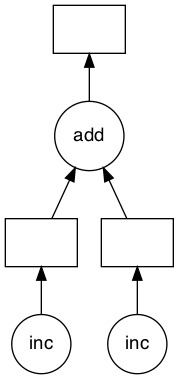

In [21]:
z.visualize()

The diagram above is that of a high-level graph. Low-level graphs will be more complicated then this.

**2) Futures**:

All the dask interfaces we have shown above, contains a `compute()` call to actually execute the function. Futures execute immediate. It is an extension of [concurrent.futures](https://docs.python.org/3/library/concurrent.futures.html), so the syntaxes are same.

Futures is part of the distributed package, so it runs on a distributed scheduler. Keep in mind that distributed schedulers use both processes by default, but handles data locality with more sophistication, and so can be more efficient than the `Multiprocessing` scheduler on workloads that require multiple processes. Setting up a distributed scheduler is more involved then other examples we have seen before. It requires you to explictly create a `Client`.

In [1]:
from distributed import Client
client = Client()

/Users/u6533564/anaconda3/envs/coiled-mmcky-consumption-forecast/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 63807 instead
  warnings.warn(


Calling `Client` function without any argument creates a local client cluster. Each client cluster comes with a dashboard url for diagnostics. It creates workers and the number of threads created by default equal to the number of cores in your CPU. You can configure all of this.
`Client` comes with a lot of configuration options, as mentioned in the [docs](https://docs.dask.org/en/latest/setup/single-distributed.html#distributed.deploy.local.LocalCluster)

In [2]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:63807/status,
Dashboard: http://127.0.0.1:63807/status,Workers: 4
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:63808,Workers: 4
Dashboard: http://127.0.0.1:63807/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://10.158.0.6:63831,Total threads: 3
Dashboard: http://10.158.0.6:63833/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:63812,


In [3]:
client.close() # always good to close the client once computation is done

If you want to run in a single process, you can pass `processes=False` keyword.

In [5]:
client2 = Client(processes=False)
client2

/Users/u6533564/anaconda3/envs/coiled-mmcky-consumption-forecast/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 51836 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://192.168.0.102:51836/status,
Dashboard: http://192.168.0.102:51836/status,Workers: 1
Total threads: 12,Total memory: 16.00 GiB
Status: running,Using processes: False
Comm: inproc://192.168.0.102/6315/1,Workers: 1
Dashboard: http://192.168.0.102:51836/status,Total threads: 12
Started: Just now,Total memory: 16.00 GiB
Comm: inproc://192.168.0.102/6315/3,Total threads: 12
Dashboard: http://192.168.0.102:51837/status,Memory: 16.00 GiB
Nanny: None,


In [6]:
client2.close()

This can be the preferred method if your computations don't hold on to the GIL, or when your inter-worker communication overhead is quite substanial, for example, large chunks of data are being passed around. 

**An important point** to note is that, when you use the `Client` call in your program, all subsequent code use the distributed scheduler by default and execution will happen in the cluster you had specified in client. So, all the high-level APIs, delayed, specified after this function call will use distributed as their scheduler unless otherwise explicitly specified. 

A code example, to demonstrate `futures` syntax:

In [12]:
client = Client()

/Users/u6533564/anaconda3/envs/coiled-mmcky-consumption-forecast/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 55375 instead
  warnings.warn(


In [13]:
import time

def incr(x):
    time.sleep(2)
    return x + 1

def decr(x):
    time.sleep(2)
    return x - 1

def addition(x, y):
    time.sleep(1)
    return x + y

In [14]:
%%time
# This takes six seconds to run as expected
# because of the sequential nature

x = client.submit(incr, 1)
y = client.submit(decr, 2)
z = client.submit(addition, x, y)
z.result()

CPU times: user 293 ms, sys: 72.3 ms, total: 365 ms
Wall time: 3.04 s


3

In [16]:
client.close()

While introducing `futures`, we also introduced distributed scheduler with a local cluster. A truly distributed scheduler with a remote cluster will be discussed in the coiled tutorial.